# Counting Events in HDF5 data
<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [2]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import oskar
scripts = oskar.Scripts()

## Import Data

In [3]:
rid = '20160424_115511'
h5 = oskar.H5Data(rid)              # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Events")    # output
h5.pprint()

20160424_115511
   Author:	 AA,BC
   Description:  Pulser delay scan, lineshapes at each delay
		 (pulser) DLY_GA: 1.05u, 1.4u, 10u
		 (lasers) DLY_EA: 635ns
		 IR: 755.63 - 761.81 (0.06)nm
		 T = 2.2kV
		 G = 200 V
		 Initial temp: 97.1deg 


In [4]:
# data
ftype = 'CH_A0'
squid = 4
trace, info = h5.load_array(squid, ftype)
print(info)

{u'probe attenuation': 1.0, u'name': 'Channel 1', u'vertical range': 0.10000000000000001, u't0': 2.9999999999995308e-07, u'vertical coupling': 'DC', u'Model': 'DSO6104A,MY51510237,06.17.0001\n', u'input impedance': '50 ohms', u'vertical offset': -0.035000000000000003, u'dt': 6.0000000000000008e-09, u'Manufacturer': 'Agilent'}


## Trigger Settings

In [13]:
min_level = 0.004 # minimum threshold (V)
min_width = 2E-8 # minimum pulse width (s)
min_x = min_width / info['dt']

trigger : [131 141 276 401 518]
width : [  2.40000000e-08   6.06000000e-07   5.40000000e-08   4.80000000e-08
   6.60000000e-08]
amp : [-0.007409323, -0.088727027, -0.015195781, -0.010320781, -0.015500468]


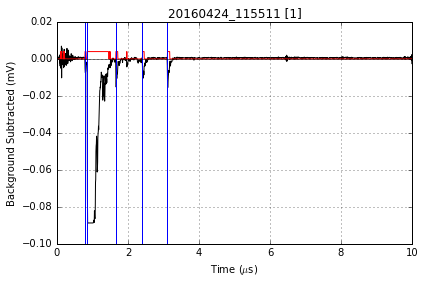

In [14]:
rep = 1
ydata = trace[rep]
offset = np.mean(ydata[:50])
ydata = ydata - offset
xdata = np.arange(len(ydata)) * info['dt'] / 1E-6

#plot
fig, ax = plt.subplots()
ax.plot(xdata, ydata, 'k')
# find where trace exceeds threshold
threshold = -ydata > min_y
ax.plot(xdata, np.int_(threshold)*min_y, '-r')
# first and last element must be False
threshold[0] = False
threshold[-1] = False
# find where True goes to False (pulse start/ stop)
rngs = np.where(np.diff(threshold))[0].reshape(-1, 2)
# find the pulses wider than the min_width
pulse = rngs[rngs[:,1]-rngs[:,0] > min_x]
#leading edge, width, and max value (assume negative)
trigger = pulse[:,0]
print "trigger : " + str(trigger)
width = (pulse[:,1] - pulse[:,0]) * info['dt']
print "width : " + str(width)
amp = [np.min(ydata[p[0]:p[1]]) for p in pulse]
print "amp : " + str(amp)
for trig in trigger:
    ax.axvline(x=xdata[trig])
    
#format
ax.set_ylabel("Background Subtracted (mV)");
ax.set_xlabel(r"Time ($\mu$s)");
plt.title(rid + ' [' + str(rep) + ']');
plt.axhline(0, color='k', alpha=0.5)
plt.axvline(0, color='k', alpha=0.5)
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "LYSO_trigger.png")
plt.savefig(fileout, dpi=300)
plt.show()

In [15]:
# find all triggers
%run $scripts.count --help

usage: count.py [-h] [-b BASE] [-d DIRE] [-r RID] [-f FTYPE [FTYPE ...]] [-n]
                [--n_bsub N_BSUB] [-l MIN_LEVEL] [-w MIN_WIDTH] [-i] [-t] [-q]
                [-v] [-s]

Count the triggers per trace in FTYPE. Output DataFrame to .pkl file.

optional arguments:
  -h, --help            show this help message and exit

HDF5 data:
  -b BASE, --base BASE  base directory, e.g. --base "Z:\Data"
  -d DIRE, --dire DIRE  data directory. Defaults to "[base]\YYYY\mm\dd\rid"
  -r RID, --rid RID     rid, e.g. --rid "20160203_185633"
  -f FTYPE [FTYPE ...], --ftype FTYPE [FTYPE ...]
                        file type(s) to read, e.g. -f "CH_A0"

trigger:
  -n, --negative        negative trigger [default: False]
  --n_bsub N_BSUB       number of data points to use for background
                        subtraction, default 50.
  -l MIN_LEVEL, --min_level MIN_LEVEL
                        trigger level (V) [default: 0.001]
  -w MIN_WIDTH, --min_width MIN_WIDTH
                        minim

In [16]:
# runtime ~ 5 mins per 24 hours of data (dt = 5 ns)
%run $scripts.count -r $rid -f "CH_A0" "CH_A1" --negative --min_level=$min_y --min_width=$min_width --n_bsub 50 -t

20160424_115511


100%|███████████████████████████████████| 730/730 [03:29<00:00,  3.42 squids/s]


CH_A0 : Found 330532  trigger events from 72962 traces, for 730 out of 730 seqs.


100%|███████████████████████████████████| 730/730 [03:07<00:00,  4.09 squids/s]


CH_A1 : Found 308245  trigger events from 72962 traces, for 730 out of 730 seqs.
